In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
from IPython.display import HTML
from IPython.display import display
import numpy as np
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy.optimize import curve_fit

from sklearn import preprocessing
from sklearn import metrics
#os.chdir("..")
print(os.getcwd())

from platform import python_version
print(python_version())

import importlib.util



/home/tmuehlenstaedt/tmuehlen80/training_dataset_size_per_class/notebooks
3.8.10


In [2]:
os.chdir("..")
os.getcwd()

'/home/tmuehlenstaedt/tmuehlen80/training_dataset_size_per_class'

In [3]:

spec_data_pred = importlib.util.spec_from_file_location("data_pred", "src/data_prep.py")
prep_data = importlib.util.module_from_spec(spec_data_pred)
spec_data_pred.loader.exec_module(prep_data)

spec_plotting_printing = importlib.util.spec_from_file_location("plotting_printing", "src/plotting_printing.py")
plotting_printing = importlib.util.module_from_spec(spec_plotting_printing)
spec_plotting_printing.loader.exec_module(plotting_printing)

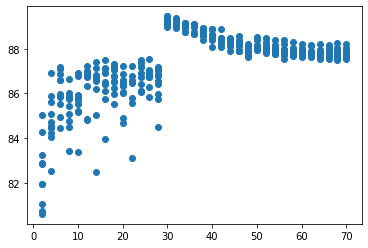

In [8]:
emnist_full = pd.read_csv("csv_files/emnistbalanced_full_dataset_trainings_mobilenet_20230920.csv")
emnist_full.head(2)
mask = emnist_full.epoch > 1
plt.scatter(emnist_full[mask].epoch, emnist_full[mask].accs)
plt.show()

### Purpose of this notebook: 

# Doing exeriments with different scaling laws

# Data prep

Please run `cifar10_datasetsize_multidim.py` before running this notebook.


In [ ]:
model_type = "exerimental"
# https://github.com/google-research/google-research/blob/master/revisiting_neural_scaling_laws/methods/m4.py
# https://arxiv.org/pdf/2209.06640.pdf

In [ ]:
results_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_20230705.csv")
results_val_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_thomas_batch_size_512_mixture_design_maximin_subsetsize_45000_val_20230708.csv")
results_4500_from_file = pd.read_csv("csv_files/Cifar10_acc_subsets_jelena_batch_size_512_mixture_design_maximin_subsetsize_4500_20230715.csv")

#prep_data
#classes, xdata, y, xdata_val, y_val, xdata_pred, xdata_4500, y_4500, results, results_val, results_4500, results_pred, results_4500_orig, results_pred_orig, xdata_last_epoch, y_last_epoch, xdata_val_last_epoch, y_val_last_epoch, xdata_total_n_epoch, xdata_val_total_n_epoch = prep_data.prep_data_all_epochs(results_from_file, 
#              results_val_from_file, 
#              results_4500_from_file, 
#              min_epoch = 20)
              
data_dict = prep_data.prep_data_all_epochs(results_from_file, 
              results_val_from_file, 
              results_4500_from_file, 
              min_epoch = 20)

# the following unpacks all dict items into a corresonding variable:
locals().update(data_dict)

In [ ]:
"otentially to be deleted "
props = dict(boxstyle='round', facecolor='white', alpha=0.5)


# m4 from paper

In [ ]:
y_hat_name = "m4"
### hm, doing m4 in the same way as the other functions is rather challenging, as it is only defined implicitely.

# powerlaw - full linear option

### Full option: 

* Fit a power law model, having the count of each level as input ... 
* ... and the number of epochs as an input as well.

In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_linear"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #result = a + d * (2 / np.pi) * np.arctan(b * (d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained) + c)
    #result = a + d * (2 / np.pi) * np.arctan(b * (d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained) + c)
    result = a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained)**b) * c
    return result 

np.random.seed(seed=4213523)
p0 = np.random.uniform(low=0, high=1, size = 14)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
xdata.shape
print(xdata.shape)
np.delete(xdata, 1, axis=1).shape
print(y.shape)
print(np.delete(y, 1).shape)
xdata[:,122]

In [ ]:
np.array(tm[1]).shape


In [ ]:
#func(xdata, *p0)

from tqdm import tqdm
from typing import Tuple

def predict_leave_one_out(x: np.ndarray,
                          y: np.ndarray,
                          f: callable,
                          p0=None,
                          bounds=(-np.inf, np.inf),
                          sample=None) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Fit power law function by the leave one out principle. Perform prediction for the left out sample.

    Args:
        x: array containing the x datapoints used to fit a power law function
        y: array containing the y datapoints used to fit a power law function
        f: the model/fitting function, f(x, ...). See curve_fit for further details.
        p0: array_like, optional argument stating the nitial guess for the parameters (length N).
            See curve_fit for further details.
        bounds: 2-tuple of array_like, optional argument stating the lower and upper bounds on parameters. Defaults
            to no bounds. See curve_fit for further details.

    Returns:
        Tuple containing arrays of the ground_truths and the predictions which were calculated by the leave one out
        principle.
    '''
    test_ground_truth = []
    test_predictions = []
    size = x.shape[1] - 1
    if sample is None:
        rangelist = range(size)
    else: 
        rangelist = np.random.choice(size, sample, replace = False).tolist()
    for i in tqdm(rangelist):
        train_x = np.delete(x, i, axis=1)
        test_x = x[:, i]
        train_y = np.delete(y, i)
        test_y = y[i]
        params, _ = curve_fit(f, train_x, train_y, maxfev=200000, p0=p0, bounds=bounds)
        y_predicted = f(test_x, *params)
        test_ground_truth.append(test_y)
        test_predictions.append(y_predicted)
    return test_ground_truth, test_predictions

tm = predict_leave_one_out(xdata, y, func, p0, bounds=(-10, 10), sample=25)
stddev = np.sqrt(np.sum((np.array(tm[0]) - np.array(tm[1]))**2) / len(tm[1]))
stddev

# hmm, this still does not work well....

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch"]
if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False)

### using an arctan effect for every class:

In [ ]:
y_hat_name = "exerimental"

def func(x, a: float, b: float, c: float, d0:float, d0_2:float, d1:float, d1_2:float, d2:float, d2_2:float, d3:float, d3_2:float, d4:float, d4_2:float, d5:float, d5_2:float, d6:float, d6_2:float, d7:float, d7_2:float, d8:float, d8_2:float, d9:float, d9_2:float, d_epochs:float, d_epoch_2:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    #result = a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**(b + b1 * (x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9))) * c
    #result = a + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**(b + b1 * (x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9))) * (c + c1 * (x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9))
    #result = a + a1 *(x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9) + ((d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained))**(b + b1 * (x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9))) * (c + c1 * (x0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9)) # did not converge,took long time
    #result = a + (2 / np.pi) * np.arctan(b * (d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained)) + c)
    #result = a + (2 / np.pi) * np.arctan(b * (d0* np.arctan(d0_2 + x0) + d1* np.arctan(d1_2 + x1)  + d2* np.arctan(d2_2 + x2) + d3 * np.arctan(d3_2 + x3) + d4 * np.arctan(d4_2 + x4) + d5 * np.arctan(d5_2 + x5) + d6 * np.arctan(d6_2 + x6) + d7 * np.arctan(d7_2 + x7) + d8 * np.arctan(d8_2 + x8) + d9 * np.arctan(d9_2 + x9) + d_epochs*np.arctan(d_epoch_2 + epochs_trained)) + c) 
    #result = a + (2 / np.pi) * np.arctan(b * (d0* np.log(d0_2 + x0) + d1* np.log(d1_2 + x1)  + d2* np.log(d2_2 + x2) + d3 * np.log(d3_2 + x3) + d4 * np.log(d4_2 + x4) + d5 * np.log(d5_2 + x5) + d6 * np.log(d6_2 + x6) + d7 * np.log(d7_2 + x7) + d8 * np.log(d8_2 + x8) + d9 * np.log(d9_2 + x9) + d_epochs*np.log(d_epoch_2 + epochs_trained)) + c)# this one works quite ok for the 45oo examle
    #result = a * np.log(d0* np.arctan(d0_2 * x0) + d1* np.arctan(d1_2 * x1)  + d2* np.arctan(d2_2 * x2) + d3 * np.arctan(d3_2 * x3) + d4 * np.arctan(d4_2 * x4) + d5 * np.arctan(d5_2 * x5) + d6 * np.arctan(d6_2 * x6) + d7 * np.arctan(d7_2 * x7) + d8 * np.arctan(d8_2 * x8) + d9 * np.arctan(d9_2 * x9) + d_epochs*np.arctan(d_epoch_2 * epochs_trained) + b) +  c    
    result = a * np.log(d0 * x0 ** d0_2  + d1 * x1 ** d1_2 + d3 * x3 ** d3_2 + d4 * x4 ** d4_2 + d5 * x5 ** d5_2 + d6 * x6 ** d6_2 + d7 * x7 ** d7_2 + d8 * x8 ** d8_2 + d9 * x9 ** d9_2 + d_epochs* epochs_trained ** d_epoch_2 + b) +  c    
    return result

np.random.seed(seed=421530)
n_p = 25
p0 = np.random.uniform(low=0.2, high=1, size = n_p)
converged = False
#try:
params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(1e-5, 50))
converged = True
#except:
#    print("did not converge")
np.diag(params_cov)


In [ ]:
tm = func(xdata_val, *params)
type(tm)
pd.DataFrame(xdata_val.T).loc[pd.Series(tm).isna(),:]

In [ ]:
param_names = ["a", "b",  "c"]
for c in classes:
    param_names = param_names + [f"{c}_1", f"{c}_2"]
param_names = param_names + ["epoch_1", "epoch_2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)


# all class counts linear, but including quadratic term for epoch:

In [ ]:
y_hat_name = "accs_hat_classes_linear_epoch_sq"

def func(x, a: float, b: float, c: float, d0:float, d1:float, d2:float, d3:float, d4:float, d5:float, d6:float, d7:float, d8:float, d9:float, d_epochs:float, d_epochs_sq:float) -> float:
    x0 = x[0]
    x1 = x[1]
    x2 = x[2]
    x3 = x[3]
    x4 = x[4]
    x5 = x[5]
    x6 = x[6]
    x7 = x[7]
    x8 = x[8]
    x9 = x[9]
    epochs_trained = x[10]
    return a + ((d0*x0 + d1*x1 + d2*x2 + d3*x3 + d4*x4 + d5*x5 + d6*x6 + d7*x7 + d8*x8 + d9*x9 + d_epochs*epochs_trained + d_epochs_sq * epochs_trained**2)**b) * c

np.random.seed(seed=42132457)
n_p = 15
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func, xdata, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

In [ ]:
param_names = ["a", "b", "c"]
param_names = param_names + classes + ["epoch", "epoch**2"]

if converged:
    plotting_printing.plotting_printing_all_epochs(func, model_type, y_hat_name, xdata, y, param_names,  params, results, xdata_val, y_val, results_val, xdata_4500, xdata_pred, results_pred_orig, results_4500, results_4500_orig, saving_plots=False, is_2param=False)


# using all epochs, but just overall training dataset size:

In [ ]:
#
y_hat_name = "accs_hat_total_n_epoch"

def func(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch)**b) * c

np.random.seed(seed=4342133)

p0 = np.random.uniform(low=0, high=1, size = 5)
converged = False
try:
    params, params_cov = curve_fit(func, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")


"continue from here"

In [ ]:
func_powerlaw = func

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex(float_format="{:.2f}".format))
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

In [ ]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_epochs:float, d_epochs_sq:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * x_total_n + d_epochs*x_epoch + d_epochs_sq*x_epoch**2)**b) * c

np.random.seed(seed=959486)
p0 = np.random.uniform(low=0, high=1, size = 6)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "epoch", "epoch_sq"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_sq"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))

### Using the arctan trick also for the total_n model:

In [ ]:
def func_powerlaw(x, a: float, b: float, c: float, d_total_n:float, d_total_n_2:float, d_epochs:float, d_epochs_2:float) -> float:
    x_total_n = x[0]
    x_epoch = x[1]
    return a + ((d_total_n * np.arctan(d_total_n_2 * x_total_n) + d_epochs* np.arctan( d_epochs_2 * x_epoch))**b) * c

np.random.seed(seed=92548)
n_p = 7
p0 = np.random.uniform(low=0, high=1, size = n_p)
converged = False
try:
    params, params_cov = curve_fit(func_powerlaw, xdata_total_n_epoch, y, maxfev=200000, p0=p0, bounds=(-10, 10))
    converged = True
except:
    print("did not converge")

if converged:
    param_names = ["a", "b", "c", "total_n", "total_n_2", "epoch", "epoch_2"]
    param_df = pd.DataFrame({"param_name": param_names, "param_value": params})
    param_df = param_df.set_index("param_name").T
    HTML(display(param_df))
    print(param_df.to_latex())
    y_hat = func_powerlaw(xdata_total_n_epoch, *params)
    print("train avg loss:")
    print(((y_hat - y)**2).mean())
    # dataframe for plotting:
    y_hat_name = "accs_hat_total_n_epoch_arctan"
    results[y_hat_name] = y_hat
    sns.scatterplot(data = results, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results.accs, results[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_train_{y_hat_name}.jpg")
    plt.show()
    print("rsquare train:")
    print(metrics.r2_score(results.accs, results[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results.accs, results[y_hat_name])) * (xdata_total_n_epoch.shape[1] - 1) / (xdata_total_n_epoch.shape[1] - n_p - 1))
    # val data:
    y_val_hat = func_powerlaw(xdata_val_total_n_epoch, *params)
    print("val avg loss:")
    print(((y_val_hat - y_val)**2).mean())
    # dataframe for plotting:
    results_val[y_hat_name] = y_val_hat

    sns.scatterplot(data = results_val, x="accs", y = y_hat_name, hue = "epochs_trained")
    plt.xlim((0.05, 0.9))
    plt.ylim((0.05, 0.9))
    plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
    plt.text(x=0.1, y=0.8, s=f"r-sq: {np.round(metrics.r2_score(results_val.accs, results_val[y_hat_name]), 3)}", bbox=props)
    plt.savefig(f"paper/plots/powerlaw_val_{y_hat_name}.jpg")
    plt.show()
    print("rsquare val:")
    print(metrics.r2_score(results_val.accs, results_val[y_hat_name]))
    print(1 - (1 - metrics.r2_score(results_val.accs, results_val[y_hat_name])) * (xdata_val.shape[1] - 1) / (xdata_val.shape[1] - n_p - 1))

    acc_pred = func_powerlaw(xpred, *params)
    results_pred_orig["acc_pred"] = acc_pred
    sns.scatterplot(data = results_pred_orig, x = "total_training_size", y = "acc_pred", hue="epochs_trained")
    plt.show()
    display(results_pred_orig.head(30))